<a href="https://colab.research.google.com/github/monalisapatra26/ML4Science/blob/main/Classification/Imbalanced_Dataset_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style='color:blue' align='center'>Customer Churn Prediction Using Artificial Neural Network (ANN)</h3>

Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

**Load the data**

In [ ]:
link = "https://raw.githubusercontent.com/monalisapatra26/supervised_ML_algorithms/main/customer_churn.csv"
df = pd.read_csv(link)
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5286,3235-ETOOB,Male,0,Yes,No,8,Yes,No,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.50,609.9,Yes
2793,3904-UKFRE,Male,0,No,No,4,Yes,Yes,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,80.10,336.15,No
5337,6705-LNMDD,Male,0,No,No,20,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,No,Mailed check,50.00,1003.05,No
5288,8058-INTPH,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,79.65,79.65,Yes
3128,2739-CCZMB,Male,0,No,Yes,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.35,122,No


**First of all, drop customerID column as it is of no use**

In [ ]:
df.drop('customerID',axis='columns',inplace=True)

In [ ]:
df.shape

(7043, 20)

### Counting the data samples in each class

Our dataset has two classes 1 and a 0 class. The 1 class represents the customers who will leave the bank, and the 0 class represents the customer who will not leave the bank. Counting the data samples in each class will enable us to see the class imbalance.

In [ ]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

The 0 class has 5174 data samples, and the 1 class has 1869 data samples. It shows we have a class imbalance, and we will balance the classes later on when implementing the three techniques. The 0 class is the majority class in the imbalanced dataset, and the 1 class is the minority.

In [ ]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Quick glance at above makes me realize that TotalCharges should be float but it is an object. Let's check what's going on with  this column**

In [ ]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

**Ahh... it is string. Lets convert it to numbers**

In [ ]:
pd.to_numeric(df.TotalCharges)

ValueError: ignored

# Some values seems to be not numbers but blank string. Let's find out such rows

errors = 'coerce' will ignore the errors or space. It will put NA there

isnull() will say whether there is space or not

In [ ]:
pd.to_numeric(df.TotalCharges,errors='coerce')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [ ]:
pd.to_numeric(df.TotalCharges,errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

The above thing we will serve as a dataframe, and it will serve as an index. Whereever the value is True is will print the row.

In [ ]:
df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Only 11 rows have blanks for charges. Therefore drop them as we have in total; 7043 rows

**Remove rows with space in TotalCharges**

In [ ]:
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [ ]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

In [ ]:
df1.TotalCharges.dtypes

dtype('float64')

In [ ]:
df1.TotalCharges.values

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [ ]:
#df1[df1.Churn=='No']

**Data Visualization**

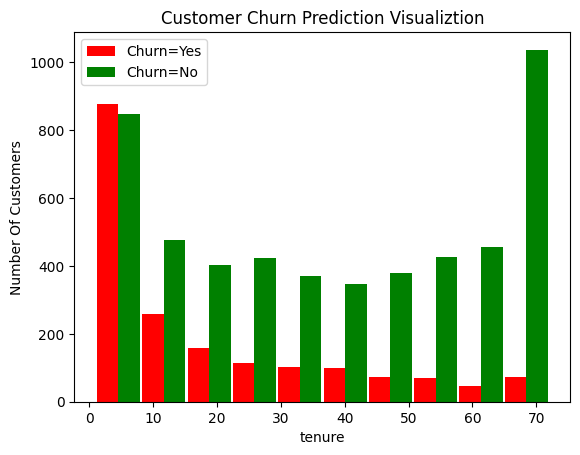

In [ ]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()
plt.show()

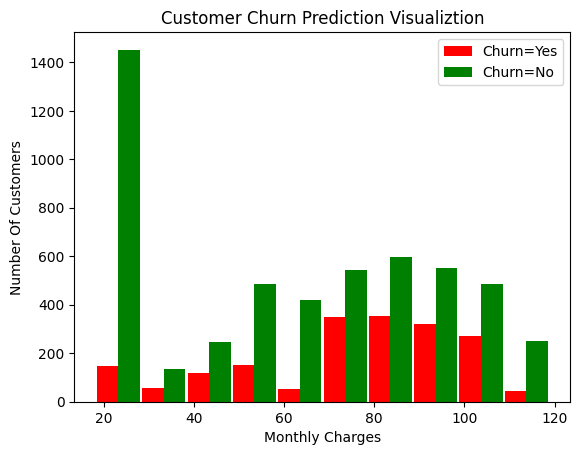

In [ ]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()
plt.show()

**Many of the columns are yes, no etc. Let's print unique values in object columns to see data values**

In [ ]:
for column in df:
    print(column)

gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn


In [ ]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

In [ ]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some of the columns have no internet service or no phone service, that can be replaced with a simple No**

In [ ]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

In [ ]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Convert Yes and No to 1 or 0**

In [ ]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

In [ ]:
for col in df1:
    print(f'{col}: {df1[col].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [ ]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

In [ ]:
#df1.gender.unique()

array([1, 0])

**One hot encoding for categorical columns**

In [ ]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
#df2.columns

In [ ]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3978,0,0,0,0,3,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
4183,0,0,0,1,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
1052,1,0,0,0,40,1,1,0,0,1,...,1,0,0,0,1,0,0,0,0,1
3465,0,0,0,0,4,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2923,0,0,0,0,54,1,0,1,0,1,...,0,1,0,1,0,0,0,0,0,1


In [ ]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

In [ ]:
#df2.sample(4)

In [ ]:
#for col in df2:
#    print(f'{col}: {df2[col].unique()}')

**Train test split**

In [ ]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [ ]:
X_train.shape

(5625, 26)

In [ ]:
X_test.shape

(1407, 26)

We now need to scale our data

In [ ]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [ ]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5664,1,1,0,0,0.126761,1,0,0,0,1,...,0,1,0,1,0,0,0,1,0,0
101,1,0,1,1,0.000000,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2621,0,0,1,0,0.985915,1,0,0,1,1,...,1,0,0,0,0,1,0,1,0,0
392,1,1,0,0,0.014085,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1327,0,0,1,0,0.816901,1,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
3607,1,0,0,0,0.169014,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2773,0,0,1,0,0.323944,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1936,1,0,1,0,0.704225,1,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
5387,0,0,0,0,0.042254,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4331,0,0,0,0,0.985915,1,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [ ]:
len(X_train.columns)

26

In [ ]:
y_train.value_counts()

0    4164
1    1461
Name: Churn, dtype: int64

In [ ]:
y_test.value_counts()

0    999
1    408
Name: Churn, dtype: int64

**Build a model (ANN) in tensorflow/keras**

In [ ]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
176/176 [==============================] - 1s 2ms/step - loss: 0.5636 - accuracy: 0.6876
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4289 - accuracy: 0.7947
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.7993
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4170 - accuracy: 0.8041
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4147 - accuracy: 0.8028
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4114 - accuracy: 0.8053
Epoch 7/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4095 - accuracy: 0.8043
Epoch 8/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4083 - accuracy: 0.8078
Epoch 9/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4073 - accuracy: 0.8082
Epoch 10/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4056 - accura

In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 2ms/step - loss: 0.4937 - accuracy: 0.7719


[0.4936818778514862, 0.7718549966812134]

In [ ]:
yp = model.predict(X_test)
yp[:5]

44/44 [==============================] - 0s 2ms/step


array([[0.15199976],
       [0.36818612],
       [0.00218644],
       [0.74710214],
       [0.45040086]], dtype=float32)

In [ ]:
y_test[:5]

2660    0
744     0
5579    1
64      1
3287    1
Name: Churn, dtype: int64

In [ ]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
y_pred[:10]

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

In [ ]:
y_test[:10]

2660    0
744     0
5579    1
64      1
3287    1
816     1
2670    0
5920    0
1023    0
6087    0
Name: Churn, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       999
           1       0.63      0.51      0.57       408

    accuracy                           0.77      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.76      0.77      0.76      1407



The precision, recall, and f1-score values for both the classes (0 and 1) are given. You will notice that the 0 class has higher score values than the 1 class. The scores need to be almost uniform for both the classes to ensure we can trust the model.

Implementing dataset balancing using the three-techniques will ensure we give fair treatment to both classes. It will increase the performance score for the minority class.

Text(69.0, 0.5, 'Truth')

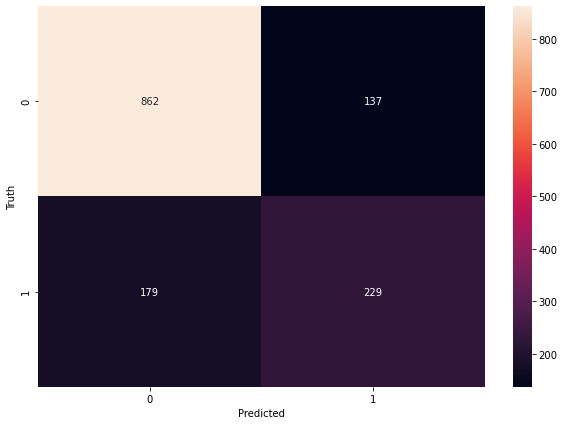

In [ ]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
y_test.shape

(1407,)

**Accuracy**

In [ ]:
#round((862+229)/(862+229+137+179),2)

**Precision for 0 class. i.e. Precision for customers who did not churn**

In [ ]:
#round(862/(862+179),2)

**Precision for 1 class. i.e. Precision for customers who actually churned**

In [ ]:
#round(229/(229+137),2)

**Recall for 0 class**

In [ ]:
#round(862/(862+137),2)

In [ ]:
#round(229/(229+179),2)

### Taking care of Skewdness of Data
```
Now let us look at the dataset, whether it is imbalanced or not
```



In [ ]:
y_test.value_counts()

0    999
1    408
Name: Churn, dtype: int64

# Method 1: Undersampling

reference: [link text](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

In [ ]:
# Class count
count_class_0, count_class_1 = df1.Churn.value_counts()

# Divide by class
# We are saving the majority and minority classes in new variables
df_class_0 = df2[df2['Churn'] == 0]
df_class_1 = df2[df2['Churn'] == 1]

In [ ]:
df_class_0.shape

(5163, 27)

In [ ]:
df_class_1.shape

(1869, 27)

In [ ]:
df_class_0.sample(count_class_1).shape

(1869, 27)

In [ ]:
#Undersampling the zero class
df_class_0_under = df_class_0.sample(count_class_1)

In [ ]:
#After applying the sample method, we concatenate the undersampled majority class
# with the minority class. It will form a single data frame.

df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
df_test_under.shape

(3738, 27)

In [ ]:
# We now print the number of data samples in the new balanced dataset.
print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
0    1869
1    1869
Name: Churn, dtype: int64


The stratify argument will ensure that the classes remain balanced after splitting. We also use the same splitting ratio. We again feed the dataset to our deep neural network

In [ ]:
# We can see that the two classes have the same data samples.
# We have achieved a balanced dataset.
X = df_test_under.drop('Churn',axis='columns')
y = df_test_under['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [ ]:
y_train.value_counts()

0    1495
1    1495
Name: Churn, dtype: int64

Step 1: Downsample the majority class [Done]

Step 2: Upweight the downsampled class: The last step is to add example weights to the downsampled class. Say we downsampled by a factor of 10, the example weight should be 10.  An example weight of 10 means the model treats the example as 10 times as important (when computing loss) as it would an example of weight 1.

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_dim=26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)

    print(model.evaluate(X_test, y_test))

    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)

    print("Classification Report: \n", classification_report(y_test, y_preds))

    return y_preds

In [ ]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 2ms/step - loss: 0.6089 - accuracy: 0.7020
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5081 - accuracy: 0.7599
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4911 - accuracy: 0.7666
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4846 - accuracy: 0.7639
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4804 - accuracy: 0.7712
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.7689
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4732 - accuracy: 0.7716
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4723 - accuracy: 0.7726
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4704 - accuracy: 0.7699
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7726
Epoch 11/

Check classification report above. f1-score for minority class 1 improved from 0.57 to 0.77. Score for class 0 reduced to 0.73 from 0.85 but that's ok. We have more generalized classifier which classifies both classes with similar prediction score

# Method 2: Oversampling

The oversampling technique will increase the data samples in the minority class (1) to have the same number as the majority class. It will duplicate the data samples in the minority class. We will also use the Pandas sample method to perform oversampling.

In [ ]:
count_class_0, count_class_1

(5163, 1869)

In [ ]:
df_class_1.shape

(1869, 27)

In [ ]:
df_class_1.sample(200).shape

(200, 27)

In [ ]:
df_class_1.sample(2000).shape

ValueError: ignored

replace: bool, default False
It will allow or disallow sampling of the same row more than once.

In [ ]:
df_class_1.sample(2000, replace=True).shape

(2000, 27)

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_class_1_over.shape

(5163, 27)

After applying the sample method, we concatenate the oversampled minority class with the majority class. It will form a single data frame.

In [ ]:
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
0    5163
1    5163
Name: Churn, dtype: int64


In [ ]:
df_test_over

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
6,0,0,0,1,22,1,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
7,1,0,0,0,10,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,1,0,0,0,1,1,1,0,1,0,...,0,1,0,1,0,0,0,0,0,1
2127,0,0,1,0,40,0,0,1,1,1,...,1,0,0,0,1,0,0,0,1,0
1970,1,0,1,0,7,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
6179,1,1,0,0,11,1,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0


In [ ]:
X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [ ]:
# Number of classes in training Data
y_train.value_counts()

1    4130
0    4130
Name: Churn, dtype: int64

In [ ]:
loss = keras.losses.BinaryCrossentropy()
weights = -1
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 [==============================] - 3s 5ms/step - loss: 0.5540 - accuracy: 0.7127
Epoch 2/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4934 - accuracy: 0.7582
Epoch 3/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4853 - accuracy: 0.7594
Epoch 4/100
259/259 [==============================] - 1s 4ms/step - loss: 0.4822 - accuracy: 0.7669
Epoch 5/100
259/259 [==============================] - 1s 3ms/step - loss: 0.4789 - accuracy: 0.7678
Epoch 6/100
259/259 [==============================] - 1s 3ms/step - loss: 0.4755 - accuracy: 0.7712
Epoch 7/100
259/259 [==============================] - 1s 3ms/step - loss: 0.4725 - accuracy: 0.7749
Epoch 8/100
259/259 [==============================] - 1s 3ms/step - loss: 0.4698 - accuracy: 0.7752
Epoch 9/100
259/259 [==============================] - 1s 3ms/step - loss: 0.4673 - accuracy: 0.7747
Epoch 10/100
259/259 [==============================] - 1s 2ms/step - loss: 0.4629 - accura

Check classification report above. f1-score for minority class 1 improved from 0.51 to 0.79. Score for class 0 reduced to 0.77 from 0.85 but that's ok. We have more generalized classifier which classifies both classes with similar prediction score

# Method 3: SMOTE

Synthetic Minority Oversampling Technique (SMOTE) is a machine learning technique that balances the dataset classes. It generates synthetic and unique data samples for the minority class to achieve a balanced dataset. We will import SMOTE from Imbalanced-learn.

To install Imbalanced-learn, execute this command in Google Colab.

! pip install imbalanced-learn

In [ ]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [ ]:
y.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

In [ ]:
y_sm.value_counts()

0    5163
1    5163
Name: Churn, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [ ]:
# Number of classes in training Data
y_test.value_counts()

1    1033
0    1033
Name: Churn, dtype: int64

In [ ]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 [==============================] - 1s 2ms/step - loss: 0.4921 - accuracy: 0.7788
Epoch 2/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4140 - accuracy: 0.8098
Epoch 3/100
259/259 [==============================] - 0s 2ms/step - loss: 0.3911 - accuracy: 0.8222
Epoch 4/100
259/259 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 0.8310
Epoch 5/100
259/259 [==============================] - 0s 2ms/step - loss: 0.3635 - accuracy: 0.8335
Epoch 6/100
259/259 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.8379
Epoch 7/100
259/259 [==============================] - 0s 2ms/step - loss: 0.3472 - accuracy: 0.8424
Epoch 8/100
259/259 [==============================] - 0s 2ms/step - loss: 0.3432 - accuracy: 0.8418
Epoch 9/100
259/259 [==============================] - 0s 2ms/step - loss: 0.3365 - accuracy: 0.8476
Epoch 10/100
259/259 [==============================] - 0s 2ms/step - loss: 0.3341 - accura

SMOT Oversampling increases f1 score of minority class 1 from 0.57 to 0.85 (huge improvement) Also over all accuracy improves from 0.77 to 0.84

# Method 4: Use of Ensemble with Undersampling

In [ ]:
df2.Churn.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [ ]:
# Regain Original features and labels
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [ ]:
y.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [ ]:
y_train.value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

In [ ]:
4130/1495

2.762541806020067

In [ ]:
4130/3

1376.6666666666667

model1 --> class1(1495) + class0(0, 1495)

model2 --> class1(1495) + class0(1496, 2990)

model3 --> class1(1495) + class0(2990, 4130)

In [ ]:
df3 = X_train.copy()
df3['Churn'] = y_train

In [ ]:
df3.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
684,1,0,0,0,0.000000,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2446,1,0,0,0,0.239437,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1
1680,0,0,1,1,0.774648,1,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2220,0,0,1,0,1.000000,1,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0
2842,1,0,0,0,0.042254,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
df3_class0 = df3[df3.Churn==0]
df3_class1 = df3[df3.Churn==1]

In [ ]:
df3_class0.shape, df3_class1.shape

((4130, 27), (1495, 27))

In [ ]:
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    return X_train, y_train

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 0, 1495)

y_pred1 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 2ms/step - loss: 0.6017 - accuracy: 0.7013
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5100 - accuracy: 0.7538
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4969 - accuracy: 0.7632
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4899 - accuracy: 0.7659
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.7666
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4824 - accuracy: 0.7686
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4815 - accuracy: 0.7682
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.7712
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4780 - accuracy: 0.7722
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4772 - accuracy: 0.7692
Epoch 11/

In [ ]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 1495, 2990)

y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 2ms/step - loss: 0.5966 - accuracy: 0.7097
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5081 - accuracy: 0.7609
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4942 - accuracy: 0.7599
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4885 - accuracy: 0.7615
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4827 - accuracy: 0.7609
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4811 - accuracy: 0.7659
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.7649
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4755 - accuracy: 0.7645
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4716 - accuracy: 0.7666
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4699 - accuracy: 0.7692
Epoch 11/

In [ ]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 2990, 4130)

y_pred3 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
83/83 [==============================] - 1s 2ms/step - loss: 0.5885 - accuracy: 0.6812
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.5182 - accuracy: 0.7560
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4994 - accuracy: 0.7605
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4888 - accuracy: 0.7696
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4817 - accuracy: 0.7700
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4770 - accuracy: 0.7738
Epoch 7/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4739 - accuracy: 0.7784
Epoch 8/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4701 - accuracy: 0.7780
Epoch 9/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4677 - accuracy: 0.7825
Epoch 10/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4655 - accuracy: 0.7810
Epoch 11/

y1 = 0 y2 = 1 y3 = 1  = 2

y1 = 0 y2 =0 y3 = 0  = 0

y1 = 0 y2 =0 y3 = 1  = 1

y1 = 1 y2 = 1 y3 =1 =  3

In [ ]:
v1 =1
v2 = 1
v3 = 0
print(v1+v2+v3)

2


Anything greater than 1 is one. Our final prediction is the majority

In [ ]:
len(y_pred1),len(y_pred2),len(y_pred3)

(1407, 1407, 1407)

In [ ]:
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n_ones = y_pred1[i] + y_pred2[i] + y_pred3[i]
    if n_ones>1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [ ]:
cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      1033
           1       0.47      0.77      0.59       374

    accuracy                           0.71      1407
   macro avg       0.68      0.73      0.68      1407
weighted avg       0.78      0.71      0.73      1407



f1-score for minority class 1 improved to 0.59 from 0.55. The score for majority class 0 is suffering and reduced to 0.80 from 0.85 but at least there is some balance in terms of prediction accuracy across two classes